### 1. Import Modules + Load the Data ###

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from olist.order import Order
order = Order().get_training_data(with_distance_seller_customer=True)
from olist.seller import Seller
sellers = Seller().get_training_data()
reviews=Seller().get_review_score()
from olist.data import Olist
data = Olist().get_data()

In [16]:
# Orders dataset
orders = data['orders'].copy()
# Handle datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders = orders.set_index('order_purchase_timestamp').sort_index()

### 1 - Orders Vs. Reviews

The following plots are to get a better understanding of what kind of data we can work with.

We can then try and create a more directed approach in our analyses. 

<AxesSubplot: xlabel='review_score', ylabel='count'>

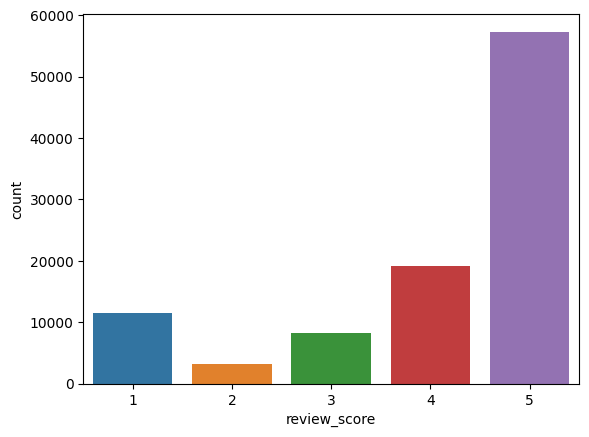

In [18]:
# Histogram of review scores
sns.countplot(x='review_score', data=data['order_reviews'])

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

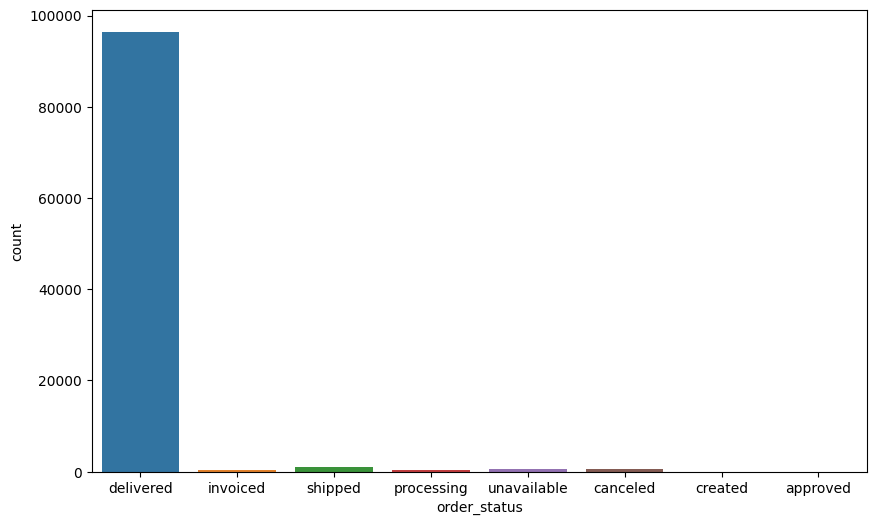

In [27]:
# Order Status of the Products
plt.figure(figsize = (10,6))
sns.countplot(data = data['orders'], x = 'order_status')
data['orders']['order_status'].value_counts()

In [29]:
# Order Status and Review Score
orders_reviews = data['orders'].merge(data['order_reviews'], on='order_id', how='left')
orders_reviews[['order_id','review_score']].isna().sum()
orders_reviews.groupby(['order_status'])['review_score'].apply(lambda s: s.isna().sum()).sort_values(ascending = False)

order_status
delivered      646
shipped         75
canceled        20
unavailable     14
processing       6
invoiced         5
created          2
approved         0
Name: review_score, dtype: int64

# Metrics
## 1. Order Numbers

Text(0.5, 1.0, 'weekly orders (total)')

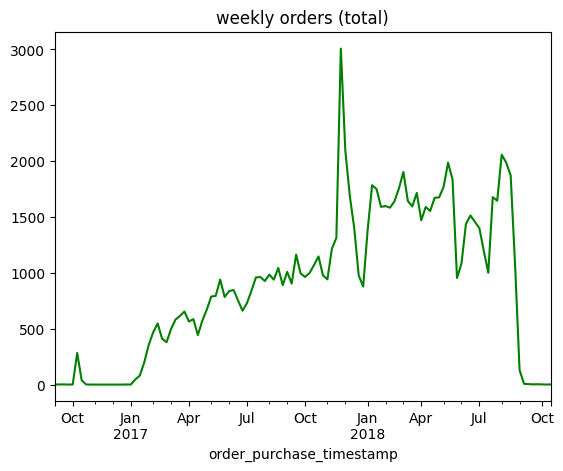

In [19]:
# Plot of our Weekly Total Orders
orders.resample('W')['order_id'].count().plot(color='g')
plt.title('weekly orders (total)')

Text(0.5, 1.0, 'weekly non-delivered orders')

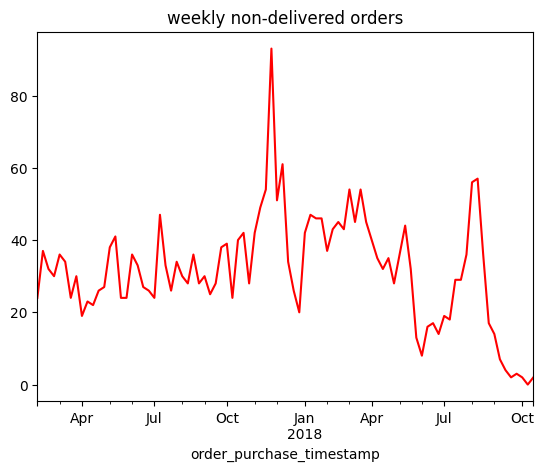

In [20]:
# Plot of our Weekly Non-Delivered Orders
orders.sort_index().query("order_status != 'delivered'").loc['2017-02-01':].resample('W')['order_id'].count().plot(color='r')
plt.title('weekly non-delivered orders')

In [21]:
# Total Payment Values
order_ids_payments = data['order_payments'].groupby('order_id').sum()[['payment_value']]
order_ids_payments.rename(columns={'payment_value': 'order_payment_value'}, inplace=True)
order_ids_payments.head()

/var/folders/wf/wz1_qkfj6p9g2bq93bwdtvlw0000gn/T/ipykernel_98274/44419887.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order_ids_payments = data['order_payments'].groupby('order_id').sum()[['payment_value']]


,order_payment_value
order_id,
00010242fe8c5a6d1ba2dd792cb16214,72.19
00018f77f2f0320c557190d7a144bdd3,259.83
000229ec398224ef6ca0657da4fc703e,216.87
00024acbcdf0a6daa1e931b038114c75,25.78
00042b26cf59d7ce69dfabb4e55b4fd9,218.04


In [22]:
orders_payments = data['orders'].merge(order_ids_payments, on='order_id')

In [23]:
# handle datetime
for col in ['order_purchase_timestamp', 'order_approved_at', \
            'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']: 
    orders_payments[col] = pd.to_datetime(orders_payments[col])
orders_payments.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,28.62


/var/folders/wf/wz1_qkfj6p9g2bq93bwdtvlw0000gn/T/ipykernel_98274/3349903570.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_orders_payments.sum()['order_payment_value'].apply(lambda x: x/1000).plot(label='Weekly payments (kR)')
/var/folders/wf/wz1_qkfj6p9g2bq93bwdtvlw0000gn/T/ipykernel_98274/3349903570.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_orders_payments.mean()['order_payment_value'].plot(label = 'Mean payments (R)')


Text(0.5, 1.0, 'Weekly orders values')

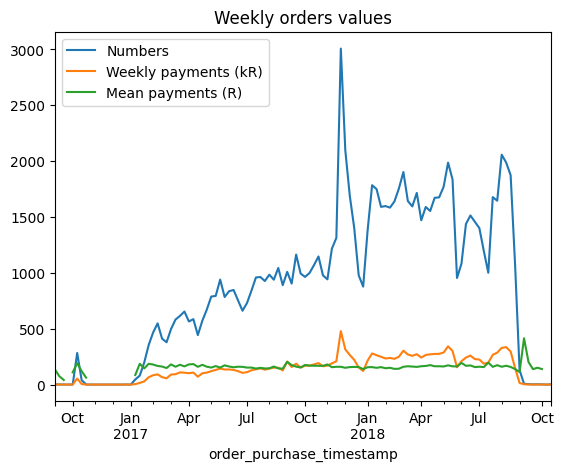

In [24]:
# Plot Weekly Order Values and Payments
weekly_orders_payments = orders_payments.set_index('order_purchase_timestamp').resample('W')
weekly_orders_payments.count()['order_id'].plot(label='Numbers')
weekly_orders_payments.sum()['order_payment_value'].apply(lambda x: x/1000).plot(label='Weekly payments (kR)')
weekly_orders_payments.mean()['order_payment_value'].plot(label = 'Mean payments (R)')
plt.legend()
plt.title('Weekly orders values')

/var/folders/wf/wz1_qkfj6p9g2bq93bwdtvlw0000gn/T/ipykernel_98274/3221748769.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax1.plot(weekly_orders_payments.sum()['order_payment_value'].apply(lambda x: x/1000),
/var/folders/wf/wz1_qkfj6p9g2bq93bwdtvlw0000gn/T/ipykernel_98274/3221748769.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax1.plot(weekly_orders_payments.mean()['order_payment_value'],


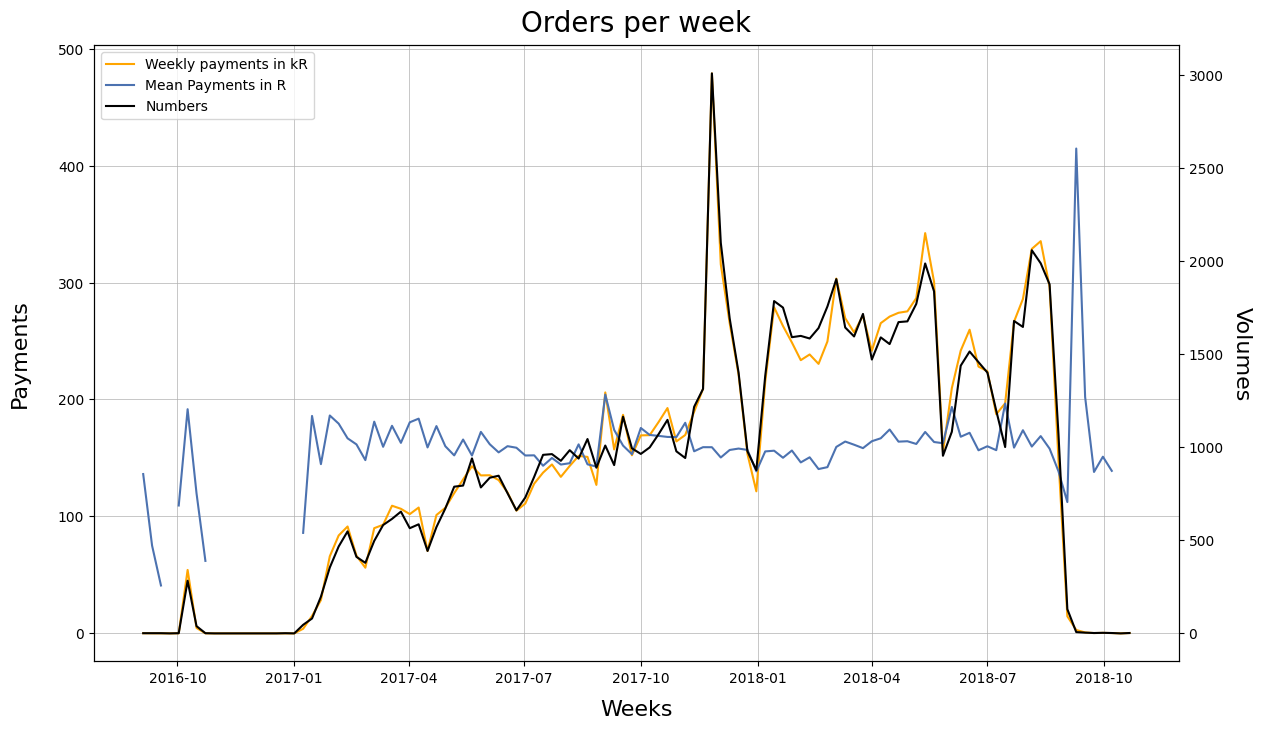

In [25]:
# Plot numbers of weekly orders purchase

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(14,8))
    # getting axes
    ax1 = plt.gca()
    # duplicating the ax1
    ax2 = ax1.twinx()
    # Weekly payments and Mean Payments
    
    ax1.plot(weekly_orders_payments.sum()['order_payment_value'].apply(lambda x: x/1000),
             color="orange",
             label="Weekly payments in kR")
    ax1.plot(weekly_orders_payments.mean()['order_payment_value'],
             label="Mean Payments in R")
    ax1.set_xlabel("Weeks", 
                   fontsize = 16, 
                   labelpad = 10)
    ax1.set_ylabel("Payments", 
                   fontsize = 16, 
                   labelpad = 20)

    # Numbers
    ax2.plot(weekly_orders_payments.count()['order_id'],
             label="Numbers",
             c="black")
    ax2.set_ylabel("Volumes", 
                   fontsize = 16, 
                   rotation = 90*3, 
                   labelpad = 20)

    # Get a common legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    # Title
    ax1.set_title('Orders per week', 
                  fontsize = 20, 
                  pad = 10)

    # Grid
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)
    plt.show()

## 2. Customer Satisfaction

In [31]:
reviews = data['order_reviews'].copy()
reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [32]:
# Handle Datetime
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews.set_index('review_creation_date', inplace=True)

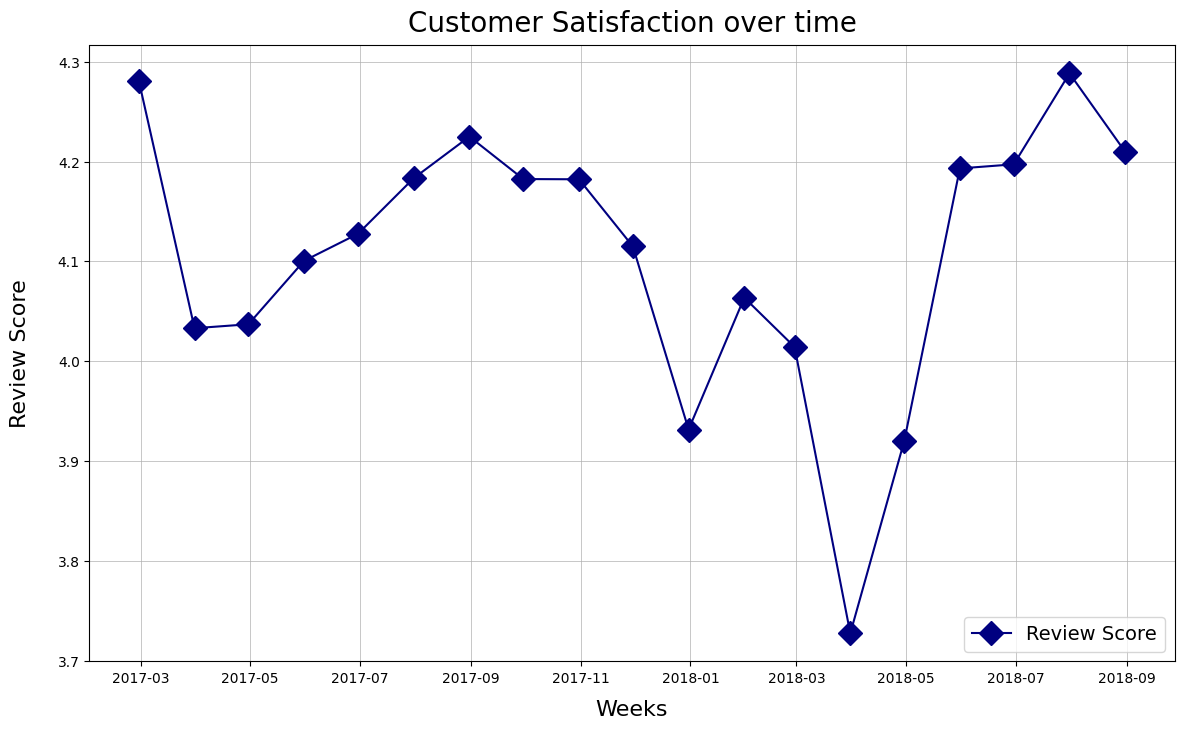

In [34]:
# Customer Satisfaction Over Time
with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(14,8))
    # getting axes
    ax = plt.gca()
    # Customer Satisfaction over time
    
    ax.plot(reviews.loc['2017-02-01':].resample('M').agg({'review_score':'mean'}),
            color = "#000080", 
            marker = "D", 
            markersize = 12,
            label="Review Score")
    ax.set_xlabel("Weeks", fontsize = 16, labelpad = 10)
    ax.set_ylabel("Review Score", fontsize = 16, labelpad = 20)

    # Get a  legend
    ax.legend(loc='lower right', fontsize = 14)

    # Title
    ax.set_title('Customer Satisfaction over time', fontsize = 20, pad = 10)

    # Grid
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    plt.show()

## 3. Shipping Delay 

In [35]:
# Computing the Shipping Delays
orders = orders.query("order_status == 'delivered'").reset_index()

In [38]:
# Fixing our Date Time Probelm
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_purcahse_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

In [39]:
# Computing the delay between the actual delivery date and the ETA for each order
orders['delay_vs_expected']=(orders['order_delivered_customer_date'] -\
                            orders['order_estimated_delivery_date']) / np.timedelta64(24, 'h')

In [40]:
# Computing the wait time between the actual delivery date and the moment a customer ordered their items
orders['wait_time'] = (orders['order_delivered_customer_date'] -\
                       orders['order_purchase_timestamp']) / np.timedelta64(24, 'h')

In [41]:
# Checking how many orders were delivered later than expected
# boolean feature that says whether an order was delivered with a delay or not
# delay_vs_expected > 0 
# <=> actual_delivered date > ETA 
# <=> actual_delivered date - ETA > 0

orders["was_late"] = orders['delay_vs_expected'].map(lambda x: x > 0)

# early_or_in_time is just a nice column but it's redundant with the was_late
orders["early_or_on_time"] = orders["was_late"].map({True:"late",False:"in_time"})

In [45]:
# On Time vs Late
orders["early_or_on_time"].value_counts()

in_time    88652
late        7826
Name: early_or_on_time, dtype: int64

In [44]:
# Percentage of On Time vs Late
round(orders["early_or_on_time"].value_counts(normalize = True),2)

in_time    0.92
late       0.08
Name: early_or_on_time, dtype: float64

In [46]:
# Finding which weeks were the worst
delay_analysis_per_week = orders.set_index('order_purchase_timestamp').resample('W').agg({
    'delay_vs_expected':np.mean,
    'wait_time':np.mean,
    'was_late':np.sum,
    'order_id':'count'})

delay_analysis_per_week.columns = ['avg_delay_vs_exp', 'avg_wait_time','nb_of_delays', 'nb_of_orders']

delay_analysis_per_week['pct_of_lateness'] = delay_analysis_per_week['nb_of_delays'] / delay_analysis_per_week['nb_of_orders']

print("-"*40)
print("Delay Analysis per week")
print("-"*40)
display(round(delay_analysis_per_week.tail(10),2))

----------------------------------------
Delay Analysis per week
----------------------------------------


,avg_delay_vs_exp,avg_wait_time,nb_of_delays,nb_of_orders,pct_of_lateness
order_purchase_timestamp,,,,,
2018-07-01,-16.78,8.33,10,1382,0.01
2018-07-08,-13.84,8.52,19,1178,0.02
2018-07-15,-9.88,11.27,59,972,0.06
2018-07-22,-10.40,9.03,65,1649,0.04
2018-07-29,-9.92,8.32,63,1610,0.04
2018-08-05,-6.57,8.66,276,2002,0.14
2018-08-12,-7.01,8.49,243,1931,0.13
2018-08-19,-8.52,7.63,133,1839,0.07
2018-08-26,-8.32,5.48,71,1054,0.07


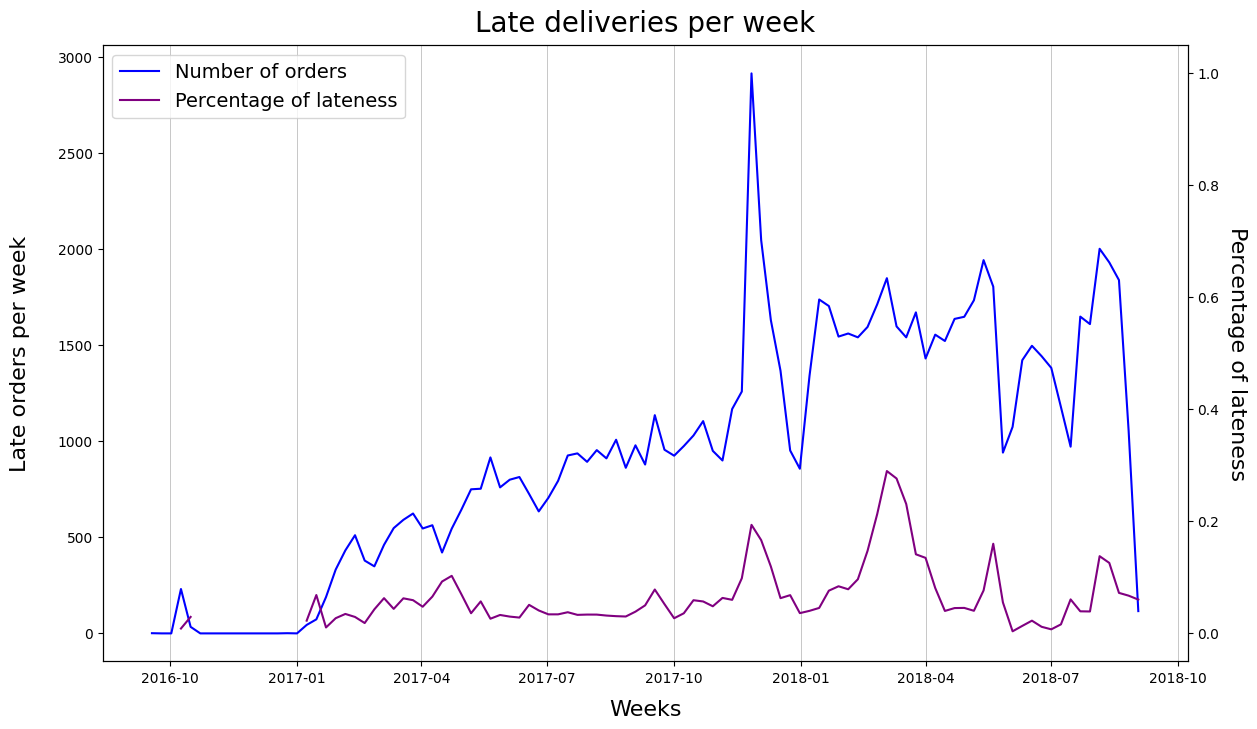

In [47]:
# Number of Delays vs the Percentage of Delayed Orders per week
with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(14,8))
    # getting axes
    ax1 = plt.gca()
    # duplicating the ax1
    ax2 = ax1.twinx()
    # Weekly payments and Mean Payments
    
    ax1.plot(delay_analysis_per_week['nb_of_orders'],
             color="blue",
             label="Number of orders")
    ax1.set_xlabel("Weeks", 
                   fontsize = 16, 
                   labelpad = 10)
    ax1.set_ylabel("Late orders per week", 
                   fontsize = 16, 
                   labelpad = 20)

    # Numbers
    ax2.plot(delay_analysis_per_week['pct_of_lateness'],
             label="Percentage of lateness",
             c="purple")
    ax2.set_ylabel("Percentage of lateness", 
                   fontsize = 16, 
                   rotation = 90*3, 
                   labelpad = 20)

    # Get a conjoined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize = 14)

    # Title
    ax1.set_title('Late deliveries per week', 
                  fontsize = 20, 
                  pad = 10)
    
    # Vertical lines
    #ax1.xvlines(x="2018-03-04")

    # Grid
    ax1.grid(axis="x",linewidth=0.5)
    plt.show()

#### Data Frame with 
* Number of Delays 
* Number of Orders 
* Percentage of Delayed Orders


In [48]:
round(delay_analysis_per_week[['nb_of_delays', 'nb_of_orders','pct_of_lateness']].sort_values(by = 'pct_of_lateness', ascending = False).head(10),2)

,nb_of_delays,nb_of_orders,pct_of_lateness
order_purchase_timestamp,,,
2016-09-18,1,1,1.00
2018-03-04,536,1849,0.29
2018-03-11,442,1598,0.28
2018-03-18,356,1541,0.23
2018-02-25,365,1713,0.21
2017-11-26,565,2915,0.19
2017-12-03,341,2047,0.17
2018-05-20,289,1805,0.16
2018-02-18,235,1595,0.15


#### Sub-Dataframe with Percentage of Delays as...
* 20% < 
* 15-20%
* 10-15%
* 5-10%
* 5% >

In [55]:
# 20% <
lateness_20_and_more = delay_analysis_per_week.query("pct_of_lateness >= 0.20")
display(round(lateness_20_and_more[1:][['nb_of_delays', 'nb_of_orders','pct_of_lateness']],2))

# 15-20%
lateness_15_20 = delay_analysis_per_week[delay_analysis_per_week["pct_of_lateness"].between(0.15,0.20)]
display(round(lateness_15_20[['nb_of_delays', 'nb_of_orders','pct_of_lateness']],2))

# 10-15%
lateness_10_15 = delay_analysis_per_week[delay_analysis_per_week["pct_of_lateness"].between(0.10,0.15)]
display(round(lateness_10_15[['nb_of_delays', 'nb_of_orders','pct_of_lateness']],2))

# 5-10%
lateness_05_10 = delay_analysis_per_week[delay_analysis_per_week["pct_of_lateness"].between(0.05,0.10)]

# 5% >
lateness_05_and_less = delay_analysis_per_week[delay_analysis_per_week["pct_of_lateness"].between(0.00,0.05)]

,nb_of_delays,nb_of_orders,pct_of_lateness
order_purchase_timestamp,,,
2018-02-25,365,1713,0.21
2018-03-04,536,1849,0.29
2018-03-11,442,1598,0.28
2018-03-18,356,1541,0.23


,nb_of_delays,nb_of_orders,pct_of_lateness
order_purchase_timestamp,,,
2017-11-26,565,2915,0.19
2017-12-03,341,2047,0.17
2018-05-20,289,1805,0.16


,nb_of_delays,nb_of_orders,pct_of_lateness
order_purchase_timestamp,,,
2017-04-23,56,545,0.10
2017-12-10,195,1631,0.12
2018-02-18,235,1595,0.15
2018-03-25,236,1671,0.14
2018-04-01,193,1431,0.13
2018-08-05,276,2002,0.14
2018-08-12,243,1931,0.13


In [56]:
lateness_brackets = pd.Series([
    " ≥ 20%",
    "15% - 20%",
    "10% - 15%",
    "5% - 10%",
    " ≤ 5%"
])

lateness_numbers = pd.Series([
    lateness_20_and_more.shape[0]-1,
    lateness_15_20.shape[0],
    lateness_10_15.shape[0],
    lateness_05_10.shape[0],
    lateness_05_and_less.shape[0]
    
])

lateness_df = pd.concat([lateness_brackets,lateness_numbers],axis = 1)
lateness_df.columns = ['brackets', 'nb_weeks']

display(lateness_df)

,brackets,nb_weeks
0,≥ 20%,4
1,15% - 20%,3
2,10% - 15%,7
3,5% - 10%,30
4,≤ 5%,46


### Amongst the 90 weeks at OLIST
* there are 4 weeks for which more than 20% of the orders were delivered way later than expected
* there are 3 weeks for which more 15-20% of the orders were delivered way later than expected
* there are 7 weeks for which more 10-15% of the orders were delivered way later than expected
